## Imports

In [1]:
import numpy as np
import pickle
import os
from MyDataset import MyDataset
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms, models
from torch.nn import functional as F
from tqdm.auto import tqdm
# from PIL import Image
import torchvision.models as models
resnet18 = models.resnet18(pretrained=True)
%matplotlib inline

## Transform raw data

In [2]:
pre_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    #transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
    transforms.RandomCrop(200),
    transforms.RandomVerticalFlip(),
    transforms.Resize((224,224)),
    transforms.ToTensor()
])
val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

## Load Data

In [3]:
train_dataset = MyDataset("./train",pre_transform)
val_dataset = MyDataset("./validate",val_transform)

In [4]:
print("train data length: %d  valid data length % d"%(len(train_dataset),len(val_dataset)))

train data length: 1754  valid data length  306


## Visualize Traning Data

In [5]:
list(resnet18.children())

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

## Define Model & Loss

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1  = nn.Conv2d(4, 3, 3, 1, 1)
        self.extractor = nn.Sequential(*list(resnet18.children())[:-2]).cuda()
        for param in list(self.extractor.parameters()):
            param.requires_grad = False
        
        self.conv3 = nn.Conv2d(512,512,3,1,1)
        #self.AAP = F.max_pool2d(x, 2)
        self.fc1 = nn.Linear(4608, 128)
        self.fc2 = nn.Linear(128, 3)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.extractor(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.max_pool2d(x, 2)
        #print(x.shape)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        #x = F.relu(x)
        #output = F.softmax(x, dim=1)
        return x

In [7]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True, pin_memory=False)

In [8]:
model = Net()
print(model)

Net(
  (conv1): Conv2d(4, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchN

In [9]:
#criterion = nn.CrossEntropyLoss()

## LDAM Loss

In [10]:
class LDAMLoss(nn.Module):
    
    def __init__(self, cls_num_list, max_m=0.5, weight=None, s=30):
        super(LDAMLoss, self).__init__()
        m_list = 1.0 / np.sqrt(np.sqrt(cls_num_list))
        m_list = m_list * (max_m / np.max(m_list))
        m_list = torch.cuda.FloatTensor(m_list)
        self.m_list = m_list
        assert s > 0
        self.s = s
        self.weight = weight

    def forward(self, x, target):
        index = torch.zeros_like(x, dtype=torch.uint8)
        index.scatter_(1, target.data.view(-1, 1), 1)
        
        index_float = index.type(torch.cuda.FloatTensor)
        batch_m = torch.matmul(self.m_list[None, :], index_float.transpose(0,1))
        batch_m = batch_m.view((-1, 1))
        x_m = x - batch_m
    
        output = torch.where(index, x_m, x)
        return F.cross_entropy(self.s*output, target, weight=self.weight)

In [11]:
def LDAMLoss(output, target, n_class_nil, n_class_MOD, n_class_SEV, C):
    loss = 0
    n_class = [n_class_nil, n_class_MOD, n_class_SEV]
    #output_class = output.argmax(dim=1, keepdim=False) #Shape [64], the predict class
    niter = output.shape[0] # 64 for a batch
    for i in range(niter):
        Z_y = output[i][target[i]]
        delta_y = C / (n_class[target[i]] ** (0.25) )
        nominator = torch.exp(Z_y - delta_y)
        if (target[i] == 0):
            dinominator = nominator + torch.exp(output[i][1]) + torch.exp(output[i][2])
        elif (target[i] == 1):
            dinominator = nominator + torch.exp(output[i][0]) + torch.exp(output[i][2])
        else:
            dinominator = nominator + torch.exp(output[i][0]) + torch.exp(output[i][1])
        loss += (-torch.log(nominator/dinominator))
    return loss

In [12]:
def compute_acc(outputs, targets):
    preds = outputs.argmax(dim=1, keepdim=True)
    return preds.eq(targets.view_as(preds)).sum().item() / targets.shape[0]

In [13]:
def performance_eval(outputs, targets):
    preds = outputs.argmax(dim=1, keepdim=False)
    targets = targets.view_as(preds)
    performance_dict = {"NIL":0.0,"MOD":0.0, "SEV":0.0 }
    for i in range(3):
        TP = targets[preds.eq(i)].eq(i).sum().item()
        FP = (~targets[preds.eq(i)].eq(i)).sum().item()
        FN = (~preds[targets.eq(i)].eq(i)).sum().item()
        Precision =  torch.true_divide(TP,(TP + FP))
        Recall = torch.true_divide(TP,(TP + FN))
        F1 = torch.true_divide(2*(Precision*Recall),(Precision+Recall))
        performance_dict[list(performance_dict.keys())[i]] = torch.tensor([Precision,Recall,F1])
    return performance_dict

In [14]:
class AverageMeter(object):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.cnt = 0
        self.TP = torch.tensor([0,0,0])
        self.FP = torch.tensor([0,0,0])
        self.FN = torch.tensor([0,0,0])
        
    def update(self, val, outputs, targets, n=1):
        self.val = val
        self.sum += val * n
        self.cnt += n
        self.avg = self.sum / self.cnt
        preds = outputs.argmax(dim=1, keepdim=True)
        preds = preds.view(-1)
        targets = targets.view(-1)
        for i in range(3):
            self.TP[i] += targets[preds.eq(i)].eq(i).sum().item()
            self.FP[i] += (~targets[preds.eq(i)].eq(i)).sum().item()
            self.FN[i] += (~preds[targets.eq(i)].eq(i)).sum().item()

In [15]:
model = model.cuda()
#criterion = criterion.cuda()

In [16]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

In [17]:
def train_one_epoch():
    accs = AverageMeter()
    for X, y in tqdm(train_loader, leave=False):
        inputs = X.cuda()
        targets = y.cuda()
        #inputs = X
        #targets = y
        optimizer.zero_grad()
        # forward
        outputs = model(inputs)
        loss = LDAMLoss(outputs,targets,591,839,324,C = 1.0)
        loss.backward()
        optimizer.step()
        accs.update(compute_acc(outputs, targets), outputs, targets, X.size(0))
        
    return accs

In [18]:
def validate_one_epoch():
    accs = AverageMeter()
    for X, y in tqdm(val_loader, leave=False):
        inputs = X.cuda()
        targets = y.cuda()
        #inputs = X
        #targets = y
        #optimizer.zero_grad()
        # forward
        outputs = model(inputs)
        #loss = criterion(outputs, targets)
        loss = LDAMLoss(outputs,targets,192,81,33,C = 1)

        #loss.backward()
        #optimizer.step()
        accs.update(compute_acc(outputs, targets), outputs, targets, X.size(0))
    return accs  

In [19]:
best_epoch = -1
best_acc = 0.0
best_model_state = model.state_dict()
history_train_acc = []
history_val_acc = []
n_epoch = 50

for epoch in tqdm(range(n_epoch)):
    for phase in range (0,2):
        if phase == 0:
            model.train()
            accs = train_one_epoch()
            print("epoch {} train acc: {:.4f} ".format(epoch, accs.avg))
            class_names = ["NIL","MOD","SEV"]
            for i in range(3):
                Precision =  torch.true_divide(accs.TP[i],(accs.TP[i] + accs.FP[i]))
                Recall = torch.true_divide(accs.TP[i],(accs.TP[i] + accs.FN[i]))
                F1 = torch.true_divide(2*(Precision*Recall),(Precision+Recall))
                print("class {} Precision {:.3f} Recall{:.3f} F1 {:.3f}".format(class_names[i],Precision,Recall,F1))
            history_train_acc.append(accs)
            scheduler.step()
            
        elif phase == 1:
            model.eval()
            accs = validate_one_epoch()
            print("epoch {} valid acc: {:.4f} ".format(epoch, accs.avg))
            class_names = ["NIL","MOD","SEV"]
            for i in range(3):
                Precision =  torch.true_divide(accs.TP[i],(accs.TP[i] + accs.FP[i]))
                Recall = torch.true_divide(accs.TP[i],(accs.TP[i] + accs.FN[i]))
                F1 = torch.true_divide(2*(Precision*Recall),(Precision+Recall))
                print("class {} Precision {:.3f} Recall{:.3f} F1 {:.3f}".format(class_names[i],Precision,Recall,F1))
            history_val_acc.append(accs)
            
            if accs.avg > best_acc:
                best_acc = accs.avg
                best_epoch = epoch
                best_model_state = model.state_dict()   
            
print(f'[Info] best val acc: {best_acc:.2%} at {best_epoch+1}th epoch')

epoch 0 train acc: 0.4504 
class NIL Precision 0.434 Recall0.305 F1 0.358
class MOD Precision 0.502 Recall0.677 F1 0.577
class SEV Precision 0.202 Recall0.130 F1 0.158


epoch 0 valid acc: 0.2647 
class NIL Precision nan Recall0.000 F1 nan
class MOD Precision 0.265 Recall1.000 F1 0.419
class SEV Precision nan Recall0.000 F1 nan


epoch 1 train acc: 0.5268 
class NIL Precision 0.595 Recall0.291 F1 0.391
class MOD Precision 0.513 Recall0.896 F1 0.653
class SEV Precision nan Recall0.000 F1 nan


epoch 1 valid acc: 0.2647 
class NIL Precision nan Recall0.000 F1 nan
class MOD Precision 0.265 Recall1.000 F1 0.419
class SEV Precision nan Recall0.000 F1 nan


epoch 2 train acc: 0.5228 
class NIL Precision 0.718 Recall0.181 F1 0.289
class MOD Precision 0.505 Recall0.965 F1 0.663
class SEV Precision nan Recall0.000 F1 nan


epoch 2 valid acc: 0.3725 
class NIL Precision 1.000 Recall0.172 F1 0.293
class MOD Precision 0.297 Recall1.000 F1 0.458
class SEV Precision nan Recall0.000 F1 nan


epoch 3 train acc: 0.5473 
class NIL Precision 0.947 Recall0.212 F1 0.346
class MOD Precision 0.515 Recall0.995 F1 0.679
class SEV Precision nan Recall0.000 F1 nan


epoch 3 valid acc: 0.3725 
class NIL Precision 1.000 Recall0.172 F1 0.293
class MOD Precision 0.297 Recall1.000 F1 0.458
class SEV Precision nan Recall0.000 F1 nan


epoch 4 train acc: 0.5502 
class NIL Precision 0.963 Recall0.220 F1 0.358
class MOD Precision 0.516 Recall0.995 F1 0.679
class SEV Precision nan Recall0.000 F1 nan


epoch 4 valid acc: 0.3889 
class NIL Precision 0.975 Recall0.203 F1 0.336
class MOD Precision 0.301 Recall0.988 F1 0.461
class SEV Precision nan Recall0.000 F1 nan


epoch 5 train acc: 0.5593 
class NIL Precision 0.922 Recall0.261 F1 0.406
class MOD Precision 0.521 Recall0.986 F1 0.682
class SEV Precision nan Recall0.000 F1 nan


epoch 5 valid acc: 0.3824 
class NIL Precision 1.000 Recall0.188 F1 0.316
class MOD Precision 0.300 Recall1.000 F1 0.462
class SEV Precision nan Recall0.000 F1 nan


epoch 6 train acc: 0.5593 
class NIL Precision 0.986 Recall0.244 F1 0.391
class MOD Precision 0.521 Recall0.998 F1 0.684
class SEV Precision nan Recall0.000 F1 nan


epoch 6 valid acc: 0.3824 
class NIL Precision 1.000 Recall0.188 F1 0.316
class MOD Precision 0.300 Recall1.000 F1 0.462
class SEV Precision nan Recall0.000 F1 nan


epoch 7 train acc: 0.5673 
class NIL Precision 0.839 Recall0.299 F1 0.441
class MOD Precision 0.530 Recall0.975 F1 0.687
class SEV Precision nan Recall0.000 F1 nan


epoch 7 valid acc: 0.3824 
class NIL Precision 1.000 Recall0.188 F1 0.316
class MOD Precision 0.300 Recall1.000 F1 0.462
class SEV Precision nan Recall0.000 F1 nan


epoch 8 train acc: 0.5644 
class NIL Precision 0.969 Recall0.264 F1 0.415
class MOD Precision 0.524 Recall0.994 F1 0.686
class SEV Precision nan Recall0.000 F1 nan


epoch 8 valid acc: 0.5163 
class NIL Precision 0.975 Recall0.411 F1 0.579
class MOD Precision 0.351 Recall0.975 F1 0.516
class SEV Precision nan Recall0.000 F1 nan


epoch 9 train acc: 0.5901 
class NIL Precision 0.727 Recall0.442 F1 0.549
class MOD Precision 0.555 Recall0.923 F1 0.693
class SEV Precision nan Recall0.000 F1 nan


epoch 9 valid acc: 0.5294 
class NIL Precision 0.988 Recall0.422 F1 0.591
class MOD Precision 0.362 Recall1.000 F1 0.531
class SEV Precision nan Recall0.000 F1 nan


epoch 10 train acc: 0.5724 
class NIL Precision 0.693 Recall0.401 F1 0.508
class MOD Precision 0.543 Recall0.914 F1 0.681
class SEV Precision nan Recall0.000 F1 nan


epoch 10 valid acc: 0.5065 
class NIL Precision 1.000 Recall0.385 F1 0.556
class MOD Precision 0.349 Recall1.000 F1 0.518
class SEV Precision nan Recall0.000 F1 nan


epoch 11 train acc: 0.6100 
class NIL Precision 0.822 Recall0.452 F1 0.583
class MOD Precision 0.562 Recall0.957 F1 0.708
class SEV Precision nan Recall0.000 F1 nan


epoch 11 valid acc: 0.6373 
class NIL Precision 0.916 Recall0.625 F1 0.743
class MOD Precision 0.429 Recall0.926 F1 0.586
class SEV Precision nan Recall0.000 F1 nan


epoch 12 train acc: 0.6060 
class NIL Precision 0.711 Recall0.528 F1 0.606
class MOD Precision 0.571 Recall0.895 F1 0.697
class SEV Precision nan Recall0.000 F1 nan


epoch 12 valid acc: 0.5556 
class NIL Precision 0.968 Recall0.474 F1 0.636
class MOD Precision 0.373 Recall0.975 F1 0.539
class SEV Precision nan Recall0.000 F1 nan


epoch 13 train acc: 0.6214 
class NIL Precision 0.803 Recall0.511 F1 0.625
class MOD Precision 0.572 Recall0.939 F1 0.711
class SEV Precision nan Recall0.000 F1 nan


epoch 13 valid acc: 0.4346 
class NIL Precision 1.000 Recall0.271 F1 0.426
class MOD Precision 0.319 Recall1.000 F1 0.484
class SEV Precision nan Recall0.000 F1 nan


epoch 14 train acc: 0.6078 
class NIL Precision 0.720 Recall0.526 F1 0.608
class MOD Precision 0.571 Recall0.900 F1 0.699
class SEV Precision nan Recall0.000 F1 nan


epoch 14 valid acc: 0.4935 
class NIL Precision 1.000 Recall0.365 F1 0.534
class MOD Precision 0.343 Recall1.000 F1 0.511
class SEV Precision nan Recall0.000 F1 nan


epoch 15 train acc: 0.6226 
class NIL Precision 0.777 Recall0.531 F1 0.631
class MOD Precision 0.576 Recall0.927 F1 0.711
class SEV Precision nan Recall0.000 F1 nan


epoch 15 valid acc: 0.6634 
class NIL Precision 0.915 Recall0.672 F1 0.775
class MOD Precision 0.448 Recall0.914 F1 0.602
class SEV Precision nan Recall0.000 F1 nan


epoch 16 train acc: 0.6214 
class NIL Precision 0.725 Recall0.575 F1 0.642
class MOD Precision 0.584 Recall0.894 F1 0.706
class SEV Precision nan Recall0.000 F1 nan


epoch 16 valid acc: 0.6242 
class NIL Precision 0.884 Recall0.635 F1 0.739
class MOD Precision 0.411 Recall0.852 F1 0.554
class SEV Precision nan Recall0.000 F1 nan


epoch 17 train acc: 0.6140 
class NIL Precision 0.731 Recall0.535 F1 0.618
class MOD Precision 0.576 Recall0.907 F1 0.704
class SEV Precision nan Recall0.000 F1 nan


epoch 17 valid acc: 0.5948 
class NIL Precision 0.990 Recall0.531 F1 0.692
class MOD Precision 0.394 Recall0.988 F1 0.563
class SEV Precision nan Recall0.000 F1 nan


epoch 18 train acc: 0.6351 
class NIL Precision 0.800 Recall0.560 F1 0.659
class MOD Precision 0.584 Recall0.933 F1 0.719
class SEV Precision nan Recall0.000 F1 nan


epoch 18 valid acc: 0.5654 
class NIL Precision 0.959 Recall0.490 F1 0.648
class MOD Precision 0.380 Recall0.975 F1 0.547
class SEV Precision nan Recall0.000 F1 nan


epoch 19 train acc: 0.6437 
class NIL Precision 0.770 Recall0.613 F1 0.682
class MOD Precision 0.597 Recall0.914 F1 0.723
class SEV Precision nan Recall0.000 F1 nan


epoch 19 valid acc: 0.6569 
class NIL Precision 0.933 Recall0.651 F1 0.767
class MOD Precision 0.442 Recall0.938 F1 0.601
class SEV Precision nan Recall0.000 F1 nan


epoch 20 train acc: 0.6425 
class NIL Precision 0.740 Recall0.641 F1 0.687
class MOD Precision 0.602 Recall0.892 F1 0.719
class SEV Precision nan Recall0.000 F1 nan


epoch 20 valid acc: 0.5719 
class NIL Precision 0.970 Recall0.505 F1 0.664
class MOD Precision 0.379 Recall0.963 F1 0.544
class SEV Precision nan Recall0.000 F1 nan


epoch 21 train acc: 0.6328 
class NIL Precision 0.766 Recall0.594 F1 0.669
class MOD Precision 0.586 Recall0.905 F1 0.711
class SEV Precision nan Recall0.000 F1 nan


epoch 21 valid acc: 0.5098 
class NIL Precision 0.987 Recall0.396 F1 0.565
class MOD Precision 0.349 Recall0.988 F1 0.516
class SEV Precision nan Recall0.000 F1 nan


epoch 22 train acc: 0.6288 
class NIL Precision 0.751 Recall0.575 F1 0.651
class MOD Precision 0.586 Recall0.909 F1 0.713
class SEV Precision nan Recall0.000 F1 nan


epoch 22 valid acc: 0.6209 
class NIL Precision 0.921 Recall0.604 F1 0.730
class MOD Precision 0.411 Recall0.914 F1 0.567
class SEV Precision nan Recall0.000 F1 nan


epoch 23 train acc: 0.6425 
class NIL Precision 0.787 Recall0.619 F1 0.693
class MOD Precision 0.590 Recall0.907 F1 0.715
class SEV Precision nan Recall0.000 F1 nan


epoch 23 valid acc: 0.6209 
class NIL Precision 0.919 Recall0.594 F1 0.722
class MOD Precision 0.418 Recall0.938 F1 0.578
class SEV Precision nan Recall0.000 F1 nan


epoch 24 train acc: 0.6431 
class NIL Precision 0.750 Recall0.636 F1 0.689
class MOD Precision 0.600 Recall0.896 F1 0.719
class SEV Precision nan Recall0.000 F1 nan


epoch 24 valid acc: 0.6993 
class NIL Precision 0.922 Recall0.734 F1 0.817
class MOD Precision 0.477 Recall0.901 F1 0.624
class SEV Precision nan Recall0.000 F1 nan


epoch 25 train acc: 0.6345 
class NIL Precision 0.706 Recall0.645 F1 0.674
class MOD Precision 0.603 Recall0.872 F1 0.713
class SEV Precision nan Recall0.000 F1 nan


epoch 25 valid acc: 0.5163 
class NIL Precision 0.975 Recall0.406 F1 0.574
class MOD Precision 0.354 Recall0.988 F1 0.521
class SEV Precision nan Recall0.000 F1 nan


epoch 26 train acc: 0.6454 
class NIL Precision 0.766 Recall0.636 F1 0.695
class MOD Precision 0.599 Recall0.901 F1 0.719
class SEV Precision nan Recall0.000 F1 nan


epoch 26 valid acc: 0.6242 
class NIL Precision 0.927 Recall0.599 F1 0.728
class MOD Precision 0.418 Recall0.938 F1 0.578
class SEV Precision nan Recall0.000 F1 nan


epoch 27 train acc: 0.6608 
class NIL Precision 0.781 Recall0.663 F1 0.717
class MOD Precision 0.613 Recall0.914 F1 0.734
class SEV Precision nan Recall0.000 F1 nan


epoch 27 valid acc: 0.5882 
class NIL Precision 0.980 Recall0.516 F1 0.676
class MOD Precision 0.395 Recall1.000 F1 0.566
class SEV Precision nan Recall0.000 F1 nan


epoch 28 train acc: 0.6494 
class NIL Precision 0.756 Recall0.655 F1 0.702
class MOD Precision 0.605 Recall0.896 F1 0.723
class SEV Precision nan Recall0.000 F1 nan


epoch 28 valid acc: 0.6863 
class NIL Precision 0.807 Recall0.807 F1 0.807
class MOD Precision 0.482 Recall0.679 F1 0.564
class SEV Precision nan Recall0.000 F1 nan


epoch 29 train acc: 0.6437 
class NIL Precision 0.693 Recall0.694 F1 0.693
class MOD Precision 0.619 Recall0.857 F1 0.719
class SEV Precision nan Recall0.000 F1 nan


epoch 29 valid acc: 0.6765 
class NIL Precision 0.875 Recall0.729 F1 0.795
class MOD Precision 0.459 Recall0.827 F1 0.590
class SEV Precision nan Recall0.000 F1 nan


epoch 30 train acc: 0.6488 
class NIL Precision 0.765 Recall0.650 F1 0.703
class MOD Precision 0.602 Recall0.899 F1 0.721
class SEV Precision nan Recall0.000 F1 nan


epoch 30 valid acc: 0.6111 
class NIL Precision 0.965 Recall0.568 F1 0.715
class MOD Precision 0.404 Recall0.963 F1 0.569
class SEV Precision nan Recall0.000 F1 nan


epoch 31 train acc: 0.6442 
class NIL Precision 0.731 Recall0.672 F1 0.700
class MOD Precision 0.605 Recall0.874 F1 0.715
class SEV Precision nan Recall0.000 F1 nan


epoch 31 valid acc: 0.5621 
class NIL Precision 0.989 Recall0.474 F1 0.641
class MOD Precision 0.379 Recall1.000 F1 0.549
class SEV Precision nan Recall0.000 F1 nan


epoch 32 train acc: 0.6602 
class NIL Precision 0.776 Recall0.682 F1 0.726
class MOD Precision 0.611 Recall0.900 F1 0.728
class SEV Precision nan Recall0.000 F1 nan


epoch 32 valid acc: 0.5654 
class NIL Precision 0.989 Recall0.484 F1 0.650
class MOD Precision 0.377 Recall0.988 F1 0.546
class SEV Precision nan Recall0.000 F1 nan


epoch 33 train acc: 0.6363 
class NIL Precision 0.740 Recall0.636 F1 0.684
class MOD Precision 0.594 Recall0.882 F1 0.710
class SEV Precision nan Recall0.000 F1 nan


epoch 33 valid acc: 0.5915 
class NIL Precision 0.962 Recall0.531 F1 0.685
class MOD Precision 0.395 Recall0.975 F1 0.562
class SEV Precision nan Recall0.000 F1 nan


epoch 34 train acc: 0.6545 
class NIL Precision 0.733 Recall0.684 F1 0.708
class MOD Precision 0.618 Recall0.887 F1 0.729
class SEV Precision nan Recall0.000 F1 nan


epoch 34 valid acc: 0.6667 
class NIL Precision 0.929 Recall0.677 F1 0.783
class MOD Precision 0.446 Recall0.914 F1 0.599
class SEV Precision nan Recall0.000 F1 nan


epoch 35 train acc: 0.6648 
class NIL Precision 0.763 Recall0.687 F1 0.723
class MOD Precision 0.622 Recall0.906 F1 0.738
class SEV Precision nan Recall0.000 F1 nan


epoch 35 valid acc: 0.6569 
class NIL Precision 0.934 Recall0.661 F1 0.774
class MOD Precision 0.435 Recall0.914 F1 0.590
class SEV Precision nan Recall0.000 F1 nan


epoch 36 train acc: 0.6579 
class NIL Precision 0.734 Recall0.701 F1 0.717
class MOD Precision 0.622 Recall0.882 F1 0.729
class SEV Precision nan Recall0.000 F1 nan


epoch 36 valid acc: 0.6471 
class NIL Precision 0.983 Recall0.609 F1 0.752
class MOD Precision 0.433 Recall1.000 F1 0.604
class SEV Precision nan Recall0.000 F1 nan


epoch 37 train acc: 0.6636 
class NIL Precision 0.782 Recall0.673 F1 0.724
class MOD Precision 0.615 Recall0.913 F1 0.735
class SEV Precision nan Recall0.000 F1 nan


epoch 37 valid acc: 0.6373 
class NIL Precision 0.952 Recall0.615 F1 0.747
class MOD Precision 0.423 Recall0.951 F1 0.586
class SEV Precision nan Recall0.000 F1 nan


epoch 38 train acc: 0.6420 
class NIL Precision 0.729 Recall0.663 F1 0.694
class MOD Precision 0.604 Recall0.875 F1 0.714
class SEV Precision nan Recall0.000 F1 nan


epoch 38 valid acc: 0.6961 
class NIL Precision 0.842 Recall0.776 F1 0.808
class MOD Precision 0.496 Recall0.790 F1 0.610
class SEV Precision nan Recall0.000 F1 nan


epoch 39 train acc: 0.6556 
class NIL Precision 0.728 Recall0.701 F1 0.714
class MOD Precision 0.621 Recall0.877 F1 0.727
class SEV Precision nan Recall0.000 F1 nan


epoch 39 valid acc: 0.6601 
class NIL Precision 0.915 Recall0.677 F1 0.778
class MOD Precision 0.439 Recall0.889 F1 0.588
class SEV Precision nan Recall0.000 F1 nan


epoch 40 train acc: 0.6642 
class NIL Precision 0.786 Recall0.682 F1 0.730
class MOD Precision 0.614 Recall0.908 F1 0.733
class SEV Precision nan Recall0.000 F1 nan


epoch 40 valid acc: 0.6209 
class NIL Precision 0.957 Recall0.583 F1 0.725
class MOD Precision 0.413 Recall0.963 F1 0.578
class SEV Precision nan Recall0.000 F1 nan


epoch 41 train acc: 0.6745 
class NIL Precision 0.810 Recall0.685 F1 0.742
class MOD Precision 0.620 Recall0.927 F1 0.743
class SEV Precision nan Recall0.000 F1 nan


epoch 41 valid acc: 0.6438 
class NIL Precision 0.912 Recall0.651 F1 0.760
class MOD Precision 0.426 Recall0.889 F1 0.576
class SEV Precision nan Recall0.000 F1 nan


epoch 42 train acc: 0.6716 
class NIL Precision 0.791 Recall0.685 F1 0.734
class MOD Precision 0.622 Recall0.921 F1 0.743
class SEV Precision nan Recall0.000 F1 nan


epoch 42 valid acc: 0.6732 
class NIL Precision 0.899 Recall0.698 F1 0.786
class MOD Precision 0.459 Recall0.889 F1 0.605
class SEV Precision nan Recall0.000 F1 nan


epoch 43 train acc: 0.6802 
class NIL Precision 0.751 Recall0.760 F1 0.755
class MOD Precision 0.644 Recall0.887 F1 0.746
class SEV Precision nan Recall0.000 F1 nan


epoch 43 valid acc: 0.6209 
class NIL Precision 0.957 Recall0.583 F1 0.725
class MOD Precision 0.413 Recall0.963 F1 0.578
class SEV Precision nan Recall0.000 F1 nan


epoch 44 train acc: 0.6722 
class NIL Precision 0.758 Recall0.719 F1 0.738
class MOD Precision 0.632 Recall0.899 F1 0.742
class SEV Precision nan Recall0.000 F1 nan


epoch 44 valid acc: 0.6601 
class NIL Precision 0.893 Recall0.693 F1 0.780
class MOD Precision 0.439 Recall0.852 F1 0.580
class SEV Precision nan Recall0.000 F1 nan


epoch 45 train acc: 0.6745 
class NIL Precision 0.757 Recall0.739 F1 0.748
class MOD Precision 0.634 Recall0.889 F1 0.740
class SEV Precision nan Recall0.000 F1 nan


epoch 45 valid acc: 0.6830 
class NIL Precision 0.902 Recall0.719 F1 0.800
class MOD Precision 0.464 Recall0.877 F1 0.607
class SEV Precision nan Recall0.000 F1 nan


epoch 46 train acc: 0.6727 
class NIL Precision 0.757 Recall0.734 F1 0.746
class MOD Precision 0.632 Recall0.889 F1 0.739
class SEV Precision nan Recall0.000 F1 nan


epoch 46 valid acc: 0.6307 
class NIL Precision 0.943 Recall0.604 F1 0.737
class MOD Precision 0.421 Recall0.951 F1 0.583
class SEV Precision nan Recall0.000 F1 nan


epoch 47 train acc: 0.6745 
class NIL Precision 0.762 Recall0.736 F1 0.749
class MOD Precision 0.632 Recall0.892 F1 0.740
class SEV Precision nan Recall0.000 F1 nan


epoch 47 valid acc: 0.6340 
class NIL Precision 0.923 Recall0.625 F1 0.745
class MOD Precision 0.420 Recall0.914 F1 0.576
class SEV Precision nan Recall0.000 F1 nan


epoch 48 train acc: 0.6682 
class NIL Precision 0.754 Recall0.717 F1 0.735
class MOD Precision 0.628 Recall0.892 F1 0.737
class SEV Precision nan Recall0.000 F1 nan


epoch 48 valid acc: 0.6961 
class NIL Precision 0.906 Recall0.750 F1 0.821
class MOD Precision 0.469 Recall0.852 F1 0.605
class SEV Precision nan Recall0.000 F1 nan


epoch 49 train acc: 0.6733 
class NIL Precision 0.730 Recall0.750 F1 0.740
class MOD Precision 0.643 Recall0.880 F1 0.743
class SEV Precision nan Recall0.000 F1 nan


epoch 49 valid acc: 0.5915 
class NIL Precision 0.963 Recall0.536 F1 0.689
class MOD Precision 0.392 Recall0.963 F1 0.557
class SEV Precision nan Recall0.000 F1 nan

[Info] best val acc: 69.93% at 25th epoch


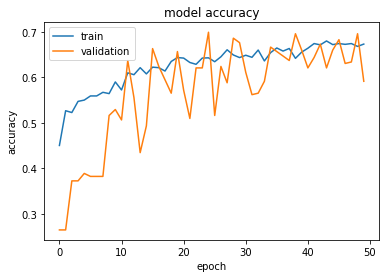

In [20]:
train_accuracy = []
val_accuracy = []
for accs in history_train_acc:
    train_accuracy.append(accs.avg)
for accs in history_val_acc:
    val_accuracy.append(accs.avg)
plt.plot(range(n_epoch),train_accuracy)
plt.plot(range(n_epoch),val_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

In [21]:
torch.save(best_model_state, "resnet_state_50.pt")

In [22]:
model.eval()
for X, y in tqdm(val_loader, leave=False):
    inputs = X.cuda()
    outputs = model(inputs)
    print("y actual:",y)
    print(outputs.argmax(dim=1, keepdim=True).view(-1))
    acc = compute_acc(outputs.cpu(), y)
    print(f'Test Acc: {acc}')

y actual: tensor([0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 2, 1, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 2, 0, 0, 1, 0, 2, 0, 0, 0, 1, 1, 0, 0, 2, 2, 0, 2, 0, 2, 1, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0])
tensor([1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1,
        0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
        0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0], device='cuda:0')
Test Acc: 0.609375
y actual: tensor([2, 1, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
        2, 0, 0, 1, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        2, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1])
tensor([1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,
        1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0], device='cuda:0')
Test Acc: 0.609375
y actual: tensor([1, 0, 1, 0, 0, 0, 2, 0

In [23]:
img, label = train_dataset.__getitem__(1700)

In [24]:
img

tensor([[[0.6196, 0.6196, 0.6627,  ..., 0.8275, 0.8275, 0.8431],
         [0.6039, 0.6039, 0.6627,  ..., 0.8275, 0.8275, 0.8431],
         [0.6039, 0.6039, 0.6627,  ..., 0.8275, 0.8275, 0.8275],
         ...,
         [0.3922, 0.3922, 0.3922,  ..., 0.3922, 0.3922, 0.3922],
         [0.3922, 0.3922, 0.3922,  ..., 0.3922, 0.3922, 0.3922],
         [0.3922, 0.3922, 0.4078,  ..., 0.3765, 0.3765, 0.3765]],

        [[0.4549, 0.4549, 0.4824,  ..., 0.5804, 0.5804, 0.6039],
         [0.4353, 0.4353, 0.4745,  ..., 0.5804, 0.5804, 0.6039],
         [0.4353, 0.4353, 0.4745,  ..., 0.5804, 0.5804, 0.5804],
         ...,
         [0.6902, 0.6902, 0.6275,  ..., 0.6392, 0.6392, 0.7725],
         [0.6902, 0.6902, 0.6275,  ..., 0.6392, 0.6392, 0.6392],
         [0.5529, 0.5529, 0.5059,  ..., 0.6000, 0.7059, 0.7059]],

        [[0.4471, 0.4471, 0.4706,  ..., 0.5725, 0.5725, 0.5961],
         [0.4235, 0.4235, 0.4706,  ..., 0.5725, 0.5725, 0.5961],
         [0.4235, 0.4235, 0.4706,  ..., 0.5725, 0.5725, 0.

In [25]:
with open("train/severe_HS_H08_20180124_0400_33.98652512_104.272.npy.pickle", 'rb') as f:
    color_img = pickle.load(f)

In [26]:
img = torch.tensor(color_img)
img = img.permute(1,2,0)
img = img/255
img.shape

torch.Size([224, 224, 4])

TypeError: Invalid shape (224, 4, 224) for image data

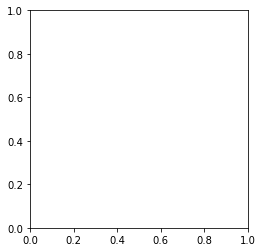

In [27]:
plt.imshow(img.permute(1,2,0))